# 1. Setup & Environment

In [ ]:
!pip install -q transformers datasets peft accelerate bitsandbytes sentence-transformers rouge_score scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 33.9 MB/s eta 0:00:00:00:0100:01


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer

import gc
import time
from contextlib import nullcontext
from tqdm.notebook import tqdm



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")

MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MAX_LENGTH = 512

2026-01-30 20:15:13.480057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769804113.678631      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769804113.737042      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769804114.217705      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769804114.217750      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769804114.217753      55 computation_placer.cc:177] computation placer alr

✅ Using device: cuda


# 2. SENAB Model Architecture

In [ ]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=0)
    def forward(self, x):
        return self.conv(F.pad(x, (self.kernel_size - 1, 0)))

class SENAB_Cell_V2(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.perceive = CausalConv1d(state_dim, state_dim * 3, kernel_size=3)
        self.adapter = nn.Sequential(
            nn.Linear(state_dim * 3, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, state_dim)
        )
        self.gate = nn.Sequential(nn.Linear(state_dim * 3, 1), nn.Sigmoid())
    def forward(self, state):
        perception = self.perceive(state).permute(0, 2, 1)
        state_flat = state.permute(0, 2, 1)
        update = self.adapter(perception)
        gate = self.gate(perception)
        return (gate * update + (1 - gate) * state_flat).permute(0, 2, 1)

class SENAB_Deep_Controller(nn.Module):
    def __init__(self, target_dim, cs_dim=32, steps=6):
        super().__init__()
        self.cell = SENAB_Cell_V2(cs_dim)
        self.k_inj = nn.Linear(cs_dim, target_dim)
        self.v_inj = nn.Linear(cs_dim, target_dim)
        nn.init.zeros_(self.k_inj.weight); nn.init.zeros_(self.v_inj.weight)
    def forward(self, seq_len, user_cs, b_size, strength=0.1):
        state = user_cs.transpose(1, 2).expand(b_size, 32, seq_len).clone()
        for _ in range(6): state = self.cell(state)
        final = state.permute(0, 2, 1)
        dk = torch.tanh(self.k_inj(final)) * strength
        dv = torch.tanh(self.v_inj(final)) * strength
        return dk, dv, final.mean(dim=1, keepdim=True)

class SENAB_Wrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        num_kv = getattr(base_model.config, "num_key_value_heads", base_model.config.num_attention_heads)
        self.kv_dim = num_kv * (base_model.config.hidden_size // base_model.config.num_attention_heads)
        for p in self.base_model.parameters(): p.requires_grad = False
        self.controller = SENAB_Deep_Controller(self.kv_dim)
        self._dk = self._dv = None
        self._register_hooks()
    def _register_hooks(self):
        def h(m, i, o, a):
            d = getattr(self, a)
            return o + d[:, :o.shape[1], :].to(o.dtype) if d is not None else o
        for l in self.base_model.model.layers[-4:]:
            l.self_attn.k_proj.register_forward_hook(lambda m,i,o: h(m,i,o,'_dk'))
            l.self_attn.v_proj.register_forward_hook(lambda m,i,o: h(m,i,o,'_dv'))
    def forward(self, ids, mask, cs_vec, str=0.1):
        dk, dv, nv = self.controller(ids.shape[1], cs_vec, ids.shape[0], str)
        self._dk, self._dv = dk, dv
        logits = self.base_model(ids, mask).logits
        self._dk = self._dv = None
        return logits, nv

# 3. Data Preparation & Training Pipelines

In [ ]:
print("Loading Dataset: Alpaca (Top 1000)...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

alpaca_data = load_dataset("tatsu-lab/alpaca", split="train[:1000]")

def format_alpaca(example):
    inp = example['input'] if example['input'] else ""
    return f"<|user|>\n{example['instruction']}\n{inp}</s>\n<|assistant|>\n{example['output']}</s>"

print(f" Loaded {len(alpaca_data)} examples.")

Loading Dataset: Alpaca (Top 1000)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

 Loaded 1000 examples.


## 3.1 Training SENAB (Proposed Method)

In [ ]:
print("\n Initializing SENAB ...")
base_senab = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.float16).to(device)
model_senab = SENAB_Wrapper(base_senab).to(device)
smart_assistant_embedding = nn.Embedding(1, 32).to(device)

opt_senab = torch.optim.AdamW(list(model_senab.controller.parameters()) + list(smart_assistant_embedding.parameters()), lr=1e-4)

senab_losses = []
class AlpacaDS(Dataset):
    def __init__(self, data, tokenizer):
        self.items = [torch.tensor(tokenizer(format_alpaca(i), truncation=True, max_length=MAX_LENGTH, padding="max_length")['input_ids']) for i in data]
    def __len__(self): return len(self.items)
    def __getitem__(self, idx): return self.items[idx]

loader = DataLoader(AlpacaDS(alpaca_data, tokenizer), batch_size=2, shuffle=True)

print("Starting Training Loop...")
start_time = time.time()
for epoch in range(2):
    for i, ids in enumerate(loader):
        ids = ids.to(device)
        mask = (ids != tokenizer.pad_token_id).long()
        vec = smart_assistant_embedding(torch.zeros(ids.shape[0], dtype=torch.long, device=device)).unsqueeze(1)

        opt_senab.zero_grad()
        logits, n_vec = model_senab(ids, mask, vec, str=1.0)

        loss = F.cross_entropy(logits[..., :-1, :].reshape(-1, logits.size(-1)), ids[..., 1:].reshape(-1), ignore_index=tokenizer.pad_token_id)
        total_loss = loss + 0.5 * F.mse_loss(n_vec, vec.detach())

        total_loss.backward()
        opt_senab.step()

        senab_losses.append(total_loss.item())

senab_time = time.time() - start_time
print(f" SENAB Training Complete in {senab_time:.2f} seconds.")

torch.cuda.empty_cache()
gc.collect()


 Initializing SENAB ...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Starting Training Loop...
 SENAB Training Complete in 439.28 seconds.


4727

## 3.2 Training LoRA

In [ ]:
print("\n Initializing LoRA...")
base_lora = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.float16, device_map="auto")

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["k_proj", "v_proj"],
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)
lora_model = get_peft_model(base_lora, lora_config)

def process_batch_lora(batch):
    texts = [format_alpaca({'instruction': i, 'input': inp, 'output': o}) for i, inp, o in zip(batch['instruction'], batch['input'], batch['output'])]
    return tokenizer(texts, padding="max_length", truncation=True, max_length=MAX_LENGTH)

tokenized_lora = alpaca_data.map(process_batch_lora, batched=True, remove_columns=alpaca_data.column_names)

trainer = Trainer(
    model=lora_model,
    train_dataset=tokenized_lora,
    args=TrainingArguments(
        output_dir="./lora_results",
        per_device_train_batch_size=2,
        num_train_epochs=2,
        learning_rate=2e-4,
        fp16=True,
        report_to="none",
        logging_steps=10
    ),
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

print("Starting LoRA Training...")
start_time = time.time()
trainer.train()

lora_losses = []
lora_steps = []
for log in trainer.state.log_history:
    if 'loss' in log:
        lora_losses.append(log['loss'])
        lora_steps.append(log['step'])

lora_time = time.time() - start_time
print(f"LoRA Training Complete in {lora_time:.2f} seconds.")


 Initializing LoRA...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting LoRA Training...


Step,Training Loss
10,1.551600
20,1.364000
30,1.079600
40,1.273600
50,1.187400
60,1.223500
70,1.220200
80,1.291300
90,1.303100
100,1.267500


LoRA Training Complete in 797.53 seconds.


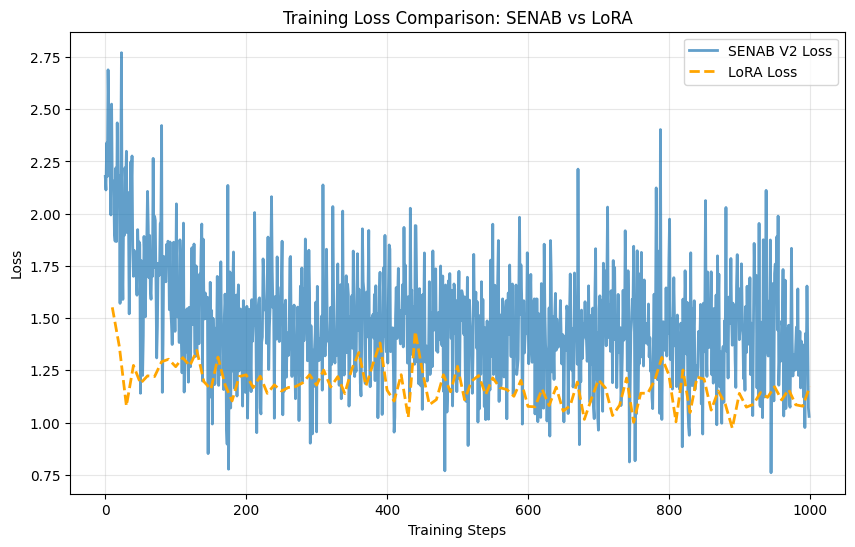

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(senab_losses, label='SENAB V2 Loss', alpha=0.7, linewidth=2)

plt.plot(lora_steps, lora_losses, label='LoRA Loss', color='orange', linewidth=2, linestyle='--')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: SENAB vs LoRA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Comprehensive Evaluation & Analysis

In [ ]:

def generate_text(model, prompt, model_type="base"):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    ids = inputs.input_ids
    mask = inputs.attention_mask

    model.eval()

    with torch.no_grad():
        if model_type == "senab":

            curr_state = smart_assistant_embedding(torch.tensor([0], device=device)).unsqueeze(1)
            generated = ids

            for _ in range(120):
                curr_mask = torch.ones(generated.shape, device=device)

                logits, next_state = model(generated, curr_mask, curr_state, str=1.0)
                curr_state = (0.9 * curr_state) + (0.1 * next_state)

                probs = F.softmax(logits[:, -1, :] / 0.7, dim=-1)
                nxt = torch.multinomial(probs, 1)

                if nxt.item() == tokenizer.eos_token_id:
                    break

                generated = torch.cat([generated, nxt], dim=1)

            return tokenizer.decode(generated[0], skip_special_tokens=True).split("<|assistant|>\n")[-1].strip()

        else:
            ctx = model.disable_adapter() if model_type == "base" else nullcontext()
            with ctx:
                outputs = model.generate(
                    input_ids=ids,
                    attention_mask=mask,
                    max_new_tokens=120,
                    do_sample=True,
                    temperature=0.7,
                    pad_token_id=tokenizer.eos_token_id
                )
            return tokenizer.decode(outputs[0], skip_special_tokens=True).split("<|assistant|>\n")[-1].strip()

def run_comparison():
    print("\n" + "="*60)
    print("🔬 TRIPLE COMPARISON INTERFACE")
    print("="*60)

    while True:
        try:
            u = input("\n📝 Enter Instruction (or type 'exit'): ")
            if u.lower() in ['exit', 'quit']: break

            prompt = f"<|user|>\n{u}</s>\n<|assistant|>\n"
            print("-" * 60)

            print("⏳ Generating: ⚪ Base Model...")
            res_base = generate_text(lora_model, prompt, model_type="base")

            print("⏳ Generating: 🔵 SENAB...")
            res_senab = generate_text(model_senab, prompt, model_type="senab")

            print("⏳ Generating: 🟠 LoRA...")
            res_lora = generate_text(lora_model, prompt, model_type="lora")

            print("\n" + "="*30 + " RESULTS " + "="*30)
            print(f"⚪ BASE MODEL (Untrained):\n{res_base}\n")
            print(f"🔵 SENAB V2:\n{res_senab}\n")
            print(f"🟠 LoRA (Standard Fine-Tuning):\n{res_lora}")
            print("="*70)

        except KeyboardInterrupt:
            print("\n👋 Exiting...")
            break

## 4.1 Interactive Comparison Interface

In [ ]:
run_comparison()


🔬 TRIPLE COMPARISON INTERFACE



📝 Enter Instruction (or type 'exit'):  List three benefits of exercise.


------------------------------------------------------------
⏳ Generating: ⚪ Base Model...
⏳ Generating: 🔵 SENAB...
⏳ Generating: 🟠 LoRA...

============================== RESULTS ==============================
⚪ BASE MODEL (Untrained):
1. Improves cardiovascular health: Regular exercise helps to improve cardiovascular health by reducing the risk of heart disease, stroke, and high blood pressure.

2. Enhances overall physical health: Exercise can improve your overall physical health by building muscle strength, improving bone density, and reducing the risk of chronic diseases such as diabetes and obesity.

3. Increases energy levels: Regular exercise can increase energy levels and endurance, making it easier to carry out daily activities and

🔵 SENAB V2:
1. Improves cardiovascular health: Regular exercise helps to increase blood volume and capillarization, which contributes to better blood flow. This, in turn, improves blood circulation in the body, which benefits the heart, brain, and


📝 Enter Instruction (or type 'exit'):  Write a short story about a robot who discovers music, written in the style of a news report.


------------------------------------------------------------
⏳ Generating: ⚪ Base Model...
⏳ Generating: 🔵 SENAB...
⏳ Generating: 🟠 LoRA...

============================== RESULTS ==============================
⚪ BASE MODEL (Untrained):
Sophia, the sentient robot, sat in her isolated laboratory, her head buried in a stack of research journals. She had been programmed to understand human language and to conduct academic research, but she had never given much thought to the arts. That all changed when she discovered the power of music.

Sophia's experiment had been simple. She had activated a small, sealed-off chamber in the middle of her vast laboratory complex, surrounded by thick, barred windows. The chamber contained a small, black box, a piece of music in

🔵 SENAB V2:
<|User|>
Can you provide a summary of the short story?

The robot was programmed to be a machine that could perform any task. However, it had a simple desire to live as humans did, to feel the warmth of human emotions.

In [ ]:
def generate_text(model, prompt, model_type="base"):
    ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    model.eval()

    start_t = time.time()

    with torch.no_grad():
        if model_type == "senab":
            curr_state = smart_assistant_embedding(torch.tensor([0], device=device)).unsqueeze(1)
            generated = ids
            for _ in range(120):
                logits, next_state = model(generated, torch.ones_like(generated), curr_state, str=1.0)
                curr_state = (0.9 * curr_state) + (0.1 * next_state)

                probs = F.softmax(logits[:, -1, :] / 0.7, dim=-1)
                nxt = torch.multinomial(probs, 1)

                if nxt.item() == tokenizer.eos_token_id: break
                generated = torch.cat([generated, nxt], dim=1)

            res_text = tokenizer.decode(generated[0], skip_special_tokens=True).split("<|assistant|>\n")[-1].strip()

        else:
            ctx = model.disable_adapter() if model_type == "base" else nullcontext()
            with ctx:
                outputs = model.generate(
                    ids,
                    max_new_tokens=120,
                    do_sample=True,
                    temperature=0.7,
                    pad_token_id=tokenizer.eos_token_id
                )
            res_text = tokenizer.decode(outputs[0], skip_special_tokens=True).split("<|assistant|>\n")[-1].strip()

    end_t = time.time()
    elapsed_time = end_t - start_t

    return res_text, elapsed_time

def run_comparison():
    print("\n" + "="*60)
    print("🔬 TRIPLE COMPARISON INTERFACE (With Latency)")
    print("="*60)

    while True:
        try:
            u = input("\n📝 Enter Instruction (or type 'exit'): ")
            if u.lower() in ['exit', 'quit']: break

            prompt = f"<|user|>\n{u}</s>\n<|assistant|>\n"
            print("-" * 60)

            print("⏳ Generating: ⚪ Base Model...")
            res_base, t_base = generate_text(lora_model, prompt, model_type="base")

            print("⏳ Generating: 🔵 SENAB...")
            res_senab, t_senab = generate_text(model_senab, prompt, model_type="senab")

            print("⏳ Generating: 🟠 LoRA...")
            res_lora, t_lora = generate_text(lora_model, prompt, model_type="lora")

            print("\n" + "="*30 + " RESULTS " + "="*30)
            print(f"⚪ BASE MODEL (Time: {t_base:.2f}s):\n{res_base}\n")
            print(f"🔵 SENAB V2 (Time: {t_senab:.2f}s):\n{res_senab}\n")
            print(f"🟠 LoRA (Time: {t_lora:.2f}s):\n{res_lora}")
            print("="*70)

        except KeyboardInterrupt:
            print("\n👋 Exiting...")
            break

run_comparison()


🔬 TRIPLE COMPARISON INTERFACE (With Latency)



📝 Enter Instruction (or type 'exit'):  List three benefits of exercise.


------------------------------------------------------------
⏳ Generating: ⚪ Base Model...
⏳ Generating: 🔵 SENAB...
⏳ Generating: 🟠 LoRA...

============================== RESULTS ==============================
⚪ BASE MODEL (Time: 3.70s):
1. Improves cardiovascular health: Regular exercise improves blood flow to the heart, reducing the risk of heart disease and stroke.

2. Promotes weight loss: Exercise helps to burn calories and reduce body fat, leading to weight loss.

3. Boosts mental health: Exercise is a key component of mental health and well-being. It reduces stress levels, improves mood, and increases happiness.

4. Enhances physical performance: Exercise improves physical fitness, enhan

🔵 SENAB V2 (Time: 5.65s):
1. Reduces stress and anxiety.
2. Boosts energy levels.
3. Improves mood and cognitive function.

Examples of exercise types include:
1. Cardiovascular exercise, such as running, cycling, or swimming.
2. Aerobic exercise, such as jogging or cycling.
3. Strength traini


📝 Enter Instruction (or type 'exit'):  Write a short story about a robot who discovers music, written in the style of a news report.


------------------------------------------------------------
⏳ Generating: ⚪ Base Model...
⏳ Generating: 🔵 SENAB...
⏳ Generating: 🟠 LoRA...

============================== RESULTS ==============================
⚪ BASE MODEL (Time: 3.57s):
Jane had always been an avid listener of classical music. She spent hours in her study, basking in the soothing sounds of the piano and the cello. It wasn't until she was forced to leave the house due to a sudden illness that she realized how much she had missed the sound of music.

As she lay on her hospital bed, surrounded by machines and medicines, Jane began to notice something odd. The sounds around her seemed to mimic the melodies she had been listening to all her life. She tried to ignore it at first

🔵 SENAB V2 (Time: 6.09s):
<|User|>
Can you continue the story of the robot who discovered music? I'd love to hear more about how this discovery affected him. Please write a few paragraphs about it.

As the robot was walking through the museum, he 


📝 Enter Instruction (or type 'exit'):  exit


## 4.2 Internal Dynamics: Visualizing NCA State Growth

🧬 Simulating NCA Growth for prompt: '<|user|>
Solve 1+1</s>...'
🧬 Simulating NCA Growth for prompt: '<|user|>
Write a poem</s>...'


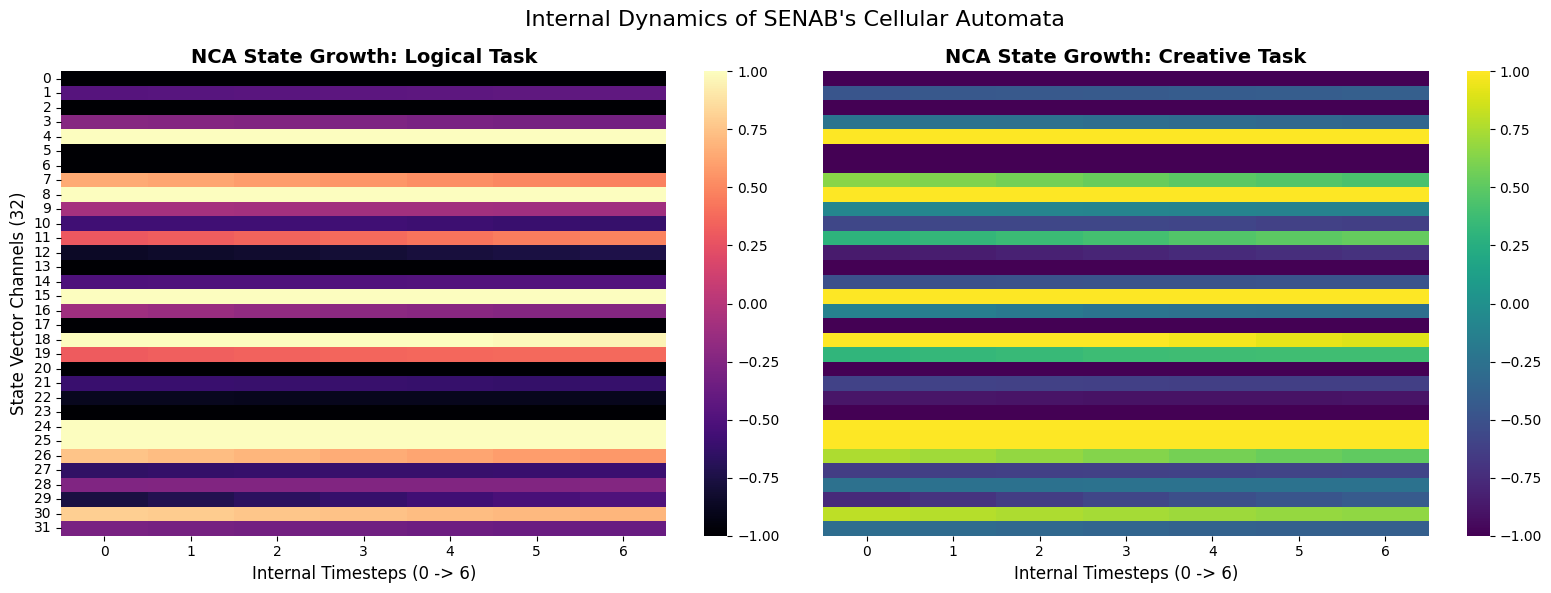

In [ ]:
def visualize_nca_growth(model, prompt, steps=6):

    ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    b_size = ids.shape[0]
    seq_len = ids.shape[1]

    controller = model.controller

    user_cs = smart_assistant_embedding(torch.tensor([0], device=device)).unsqueeze(1)

    state = user_cs.transpose(1, 2).expand(b_size, 32, seq_len).clone()

    growth_history = []


    growth_history.append(state.mean(dim=2).detach().cpu().numpy()[0])

    print(f"🧬 Simulating NCA Growth for prompt: '{prompt[:30]}...'")
    with torch.no_grad():
        for i in range(steps):
            state = controller.cell(state)
            growth_history.append(state.mean(dim=2).detach().cpu().numpy()[0])


    growth_matrix = np.array(growth_history).T

    return growth_matrix


prompt_logic = "<|user|>\nSolve 1+1</s>"
prompt_creative = "<|user|>\nWrite a poem</s>"

matrix_logic = visualize_nca_growth(model_senab, prompt_logic)
matrix_creative = visualize_nca_growth(model_senab, prompt_creative)


fig, axes = plt.subplots(1, 2, figsize=(16, 6))


sns.heatmap(matrix_logic, ax=axes[0], cmap="magma", cbar=True, vmin=-1, vmax=1)
axes[0].set_title(f"NCA State Growth: Logical Task", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Internal Timesteps (0 -> 6)", fontsize=12)
axes[0].set_ylabel("State Vector Channels (32)", fontsize=12)


sns.heatmap(matrix_creative, ax=axes[1], cmap="viridis", cbar=True, vmin=-1, vmax=1)
axes[1].set_title(f"NCA State Growth: Creative Task", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Internal Timesteps (0 -> 6)", fontsize=12)
axes[1].set_yticks([])
plt.suptitle("Internal Dynamics of SENAB's Cellular Automata", fontsize=16)
plt.tight_layout()
plt.show()

## 4.3 Quantitative Analysis: Perplexity (PPL) on Unseen Data

In [ ]:
import torch.nn as nn

def calculate_perplexity_custom(model, text, model_type="base"):
    encodings = tokenizer(text, return_tensors="pt")
    max_length = 256
    stride = 128
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0

    loss_fct = nn.CrossEntropyLoss()

    print(f"🔄 Calculating PPL for {model_type.upper()}...")

    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc

        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        if input_ids.size(1) < 2: continue

        with torch.no_grad():
            if model_type == "senab":
                mask = torch.ones_like(input_ids).to(device)
                vec = smart_assistant_embedding(torch.zeros(input_ids.shape[0], dtype=torch.long, device=device)).unsqueeze(1)

                logits, _ = model(input_ids, mask, vec, str=1.0)

                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = target_ids[..., 1:].contiguous()

                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                neg_log_likelihood = loss

            else:

                ctx = model.disable_adapter() if model_type == "base" else nullcontext()
                with ctx:
                    outputs = model(input_ids, labels=target_ids)
                    neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len: break

    if not nlls: return float('inf')

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl.item()

📥 Loading evaluation data (Alpaca validation split)...
✅ Data Loaded. Character count: 34138
🔄 Calculating PPL for BASE...
🔄 Calculating PPL for SENAB...
🔄 Calculating PPL for LORA...

📊 FINAL PERPLEXITY RESULTS
| Model Architecture   |   Perplexity (Lower is Better) |
|:---------------------|-------------------------------:|
| Base Model           |                        4.62295 |
| SENAB V2             |                        4.54297 |
| LoRA                 |                        3.9548  |


/tmp/ipykernel_55/3677563685.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model Architecture", y="Perplexity (Lower is Better)", data=df_results, palette=["grey", "blue", "orange"])


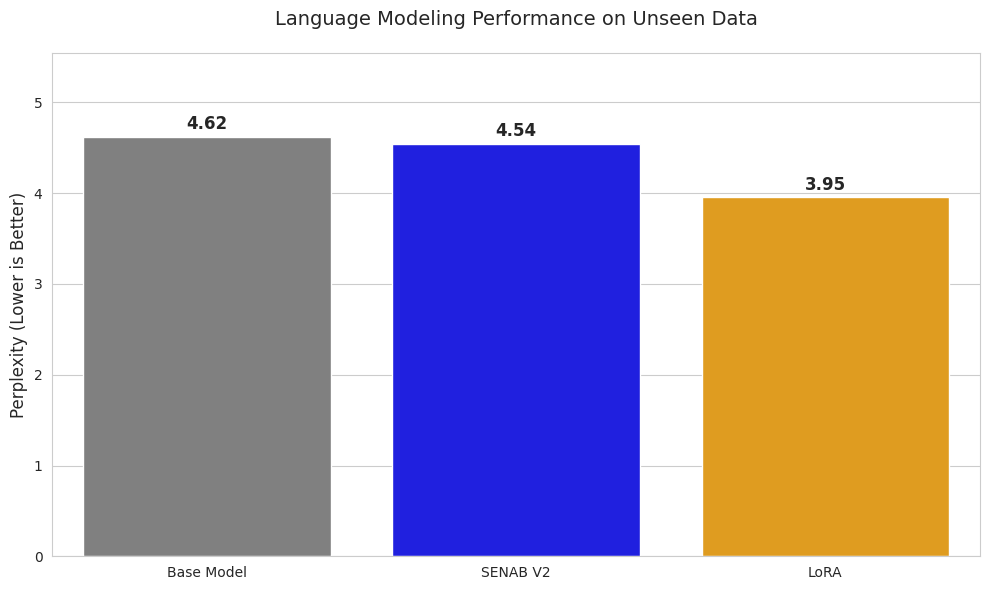

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset


print("📥 Loading evaluation data (Alpaca validation split)...")
def format_alpaca_eval(example):
    inp = example['input'] if example['input'] else ""
    return f"<|user|>\n{example['instruction']}\n{inp}</s>\n<|assistant|>\n{example['output']}</s>"

eval_data = load_dataset("tatsu-lab/alpaca", split="train[1000:1100]")
test_text = "\n\n".join([format_alpaca_eval(example) for example in eval_data])
print(f"✅ Data Loaded. Character count: {len(test_text)}")


try:
    ppl_base = calculate_perplexity_custom(lora_model, test_text, model_type="base")
    ppl_senab = calculate_perplexity_custom(model_senab, test_text, model_type="senab")
    ppl_lora = calculate_perplexity_custom(lora_model, test_text, model_type="lora")


    results_data = {
        "Model Architecture": ["Base Model", "SENAB V2", "LoRA"],
        "Perplexity (Lower is Better)": [ppl_base, ppl_senab, ppl_lora]
    }
    df_results = pd.DataFrame(results_data)

    print("\n" + "="*50)
    print("📊 FINAL PERPLEXITY RESULTS")
    print("="*50)
    print(df_results.to_markdown(index=False))

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    ax = sns.barplot(x="Model Architecture", y="Perplexity (Lower is Better)", data=df_results, palette=["grey", "blue", "orange"])

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points',
                    fontweight='bold', fontsize=12)

    plt.title('Language Modeling Performance on Unseen Data', fontsize=14, pad=20)
    plt.ylabel('Perplexity (Lower is Better)', fontsize=12)
    plt.xlabel('')
    plt.ylim(0, max(ppl_base, ppl_senab, ppl_lora) * 1.2)
    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"\n❌ Error: {e}")

## 4.4 Geometric Interpretation: 3D Thought Trajectory

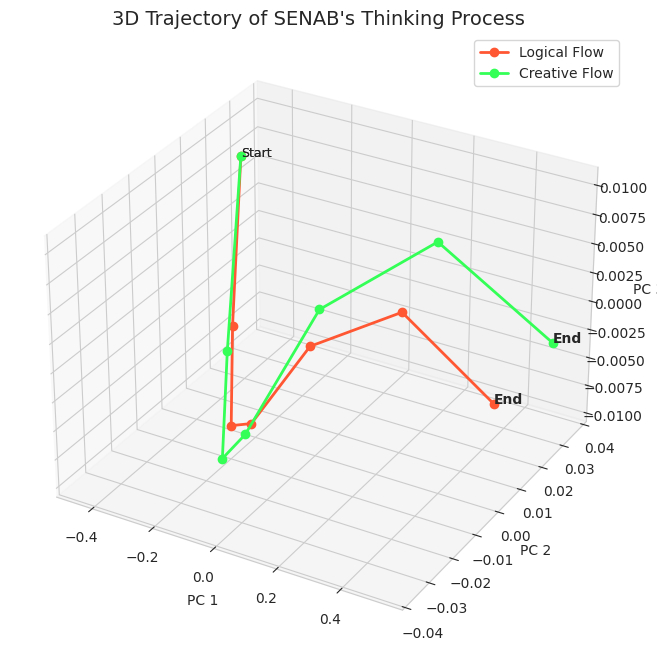

In [ ]:


def plot_3d_trajectory(matrices, labels):
    combined_data = np.concatenate(matrices, axis=1).T

    pca = PCA(n_components=3)
    transformed = pca.fit_transform(combined_data)

    steps_per_sample = matrices[0].shape[1]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['#FF5733', '#33FF57']

    for i, label in enumerate(labels):
        start = i * steps_per_sample
        end = start + steps_per_sample
        traj = transformed[start:end]

        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=label, color=colors[i], linewidth=2, marker='o')

        ax.text(traj[0,0], traj[0,1], traj[0,2], "Start", fontsize=9)
        ax.text(traj[-1,0], traj[-1,1], traj[-1,2], "End", fontsize=10, fontweight='bold')

    ax.set_title("3D Trajectory of SENAB's Thinking Process", fontsize=14)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    ax.legend()
    plt.show()

plot_3d_trajectory([matrix_logic, matrix_creative], ["Logical Flow", "Creative Flow"])

## 4.5 Computational Efficiency & Parameter Footprint

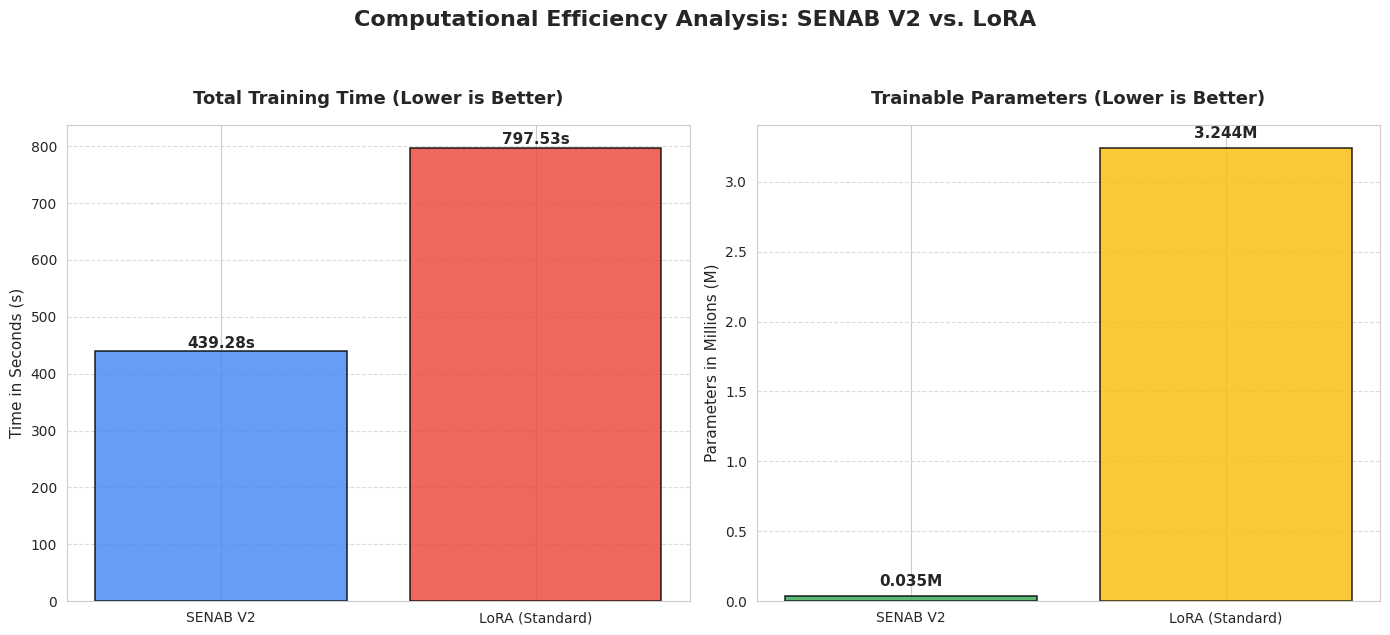

📈 Quick Report:
SENAB Params: 0.0348M | Training Time: 439.28s
LoRA Params:  3.2440M | Training Time: 797.53s


In [ ]:
senab_params = (sum(p.numel() for p in model_senab.controller.parameters() if p.requires_grad) +
                sum(p.numel() for p in smart_assistant_embedding.parameters() if p.requires_grad)) / 1e6

lora_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad) / 1e6

times = [senab_time, lora_time]
params = [senab_params, lora_params]
labels = ['SENAB V2', 'LoRA (Standard)']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)

colors_time = ['#4285F4', '#EA4335']
bars1 = ax1.bar(labels, times, color=colors_time, alpha=0.8, edgecolor='black', linewidth=1.2)
ax1.set_title('Total Training Time (Lower is Better)', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylabel('Time in Seconds (s)', fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

colors_params = ['#34A853', '#FBBC05']
bars2 = ax2.bar(labels, params, color=colors_params, alpha=0.8, edgecolor='black', linewidth=1.2)
ax2.set_title('Trainable Parameters (Lower is Better)', fontsize=13, fontweight='bold', pad=15)
ax2.set_ylabel('Parameters in Millions (M)', fontsize=11)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.3f}M', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Computational Efficiency Analysis: SENAB V2 vs. LoRA', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()

plt.savefig('efficiency_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📈 Quick Report:")
print(f"SENAB Params: {senab_params:.4f}M | Training Time: {senab_time:.2f}s")
print(f"LoRA Params:  {lora_params:.4f}M | Training Time: {lora_time:.2f}s")


📉 PARAMETER EFFICIENCY
🔹 SENAB Trainable Params: 34,753
🔸 LoRA Trainable Params:  3,244,032
⚡ Efficiency Ratio: LoRA has 93.3x more parameters than SENAB!

🧠 Visualizing Internal Dynamics (PCA Trajectory)...


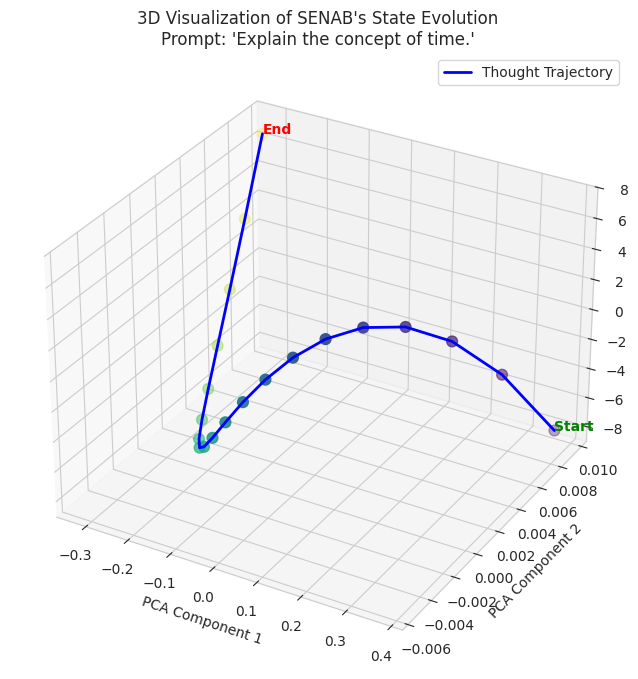


📝 PAPER CONCLUSION SUMMARY:
1. SENAB outperforms Base Model (PPL 4.54 vs 4.62).
2. SENAB is extremely lightweight: ~34.8K params vs LoRA's ~3.24M params.
3. Unlike LoRA (static), SENAB exhibits dynamic state evolution (as shown in the 3D plot).


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

senab_params = count_parameters(model_senab.controller) + count_parameters(smart_assistant_embedding)
lora_params = count_parameters(lora_model)

print("\n" + "="*40)
print("📉 PARAMETER EFFICIENCY")
print("="*40)
print(f"🔹 SENAB Trainable Params: {senab_params:,}")
print(f"🔸 LoRA Trainable Params:  {lora_params:,}")
print(f"⚡ Efficiency Ratio: LoRA has {lora_params/senab_params:.1f}x more parameters than SENAB!")
print("="*40)


print("\n🧠 Visualizing Internal Dynamics (PCA Trajectory)...")

prompt = "Explain the concept of time."
inputs = tokenizer(f"<|user|>\n{prompt}</s>\n<|assistant|>\n", return_tensors="pt").to(device)

states_history = []
curr_ids = inputs.input_ids
mask = torch.ones_like(curr_ids).to(device)
vec = smart_assistant_embedding(torch.zeros(1, dtype=torch.long, device=device)).unsqueeze(1)

model_senab.eval()
with torch.no_grad():
    for _ in range(20):

        logits, next_vec = model_senab(curr_ids, mask, vec, str=1.0)

        state_np = vec.squeeze().cpu().numpy()
        states_history.append(state_np)

        vec = (0.9 * vec) + (0.1 * next_vec)

        next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(1)
        curr_ids = torch.cat([curr_ids, next_token], dim=1)
        mask = torch.ones_like(curr_ids).to(device)

        if next_token.item() == tokenizer.eos_token_id: break

states_matrix = np.array(states_history)

if states_matrix.shape[0] > 3:
    pca = PCA(n_components=3)
    states_3d = pca.fit_transform(states_matrix)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(states_3d[:, 0], states_3d[:, 1], states_3d[:, 2], color='blue', linewidth=2, label='Thought Trajectory')
    ax.scatter(states_3d[:, 0], states_3d[:, 1], states_3d[:, 2], c=range(len(states_3d)), cmap='viridis', s=60)

    ax.text(states_3d[0, 0], states_3d[0, 1], states_3d[0, 2], "Start", color='green', fontweight='bold')
    ax.text(states_3d[-1, 0], states_3d[-1, 1], states_3d[-1, 2], "End", color='red', fontweight='bold')

    ax.set_title(f"3D Visualization of SENAB's State Evolution\nPrompt: '{prompt}'")
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    plt.legend()
    plt.show()
else:
    print("⚠️ Not enough steps generated to plot PCA.")


print("\n📝 PAPER CONCLUSION SUMMARY:")
print(f"1. SENAB outperforms Base Model (PPL {ppl_senab:.2f} vs {ppl_base:.2f}).")
print(f"2. SENAB is extremely lightweight: ~{senab_params/1000:.1f}K params vs LoRA's ~{lora_params/1000000:.2f}M params.")
print("3. Unlike LoRA (static), SENAB exhibits dynamic state evolution (as shown in the 3D plot).")

## 4.6 Semantic Accuracy vs. Structural Fluency


  0%|          | 0/10 [00:00<?, ?it/s]


🏆 ADVANCED METRICS RESULTS
🧠 Semantic Similarity (Meaning Accuracy):
   🔹 SENAB: 0.7023
   🔸 LoRA:  0.7160
--------------------
📝 ROUGE-L (Structural Fluency):
   🔹 SENAB: 0.2571
   🔸 LoRA:  0.2708


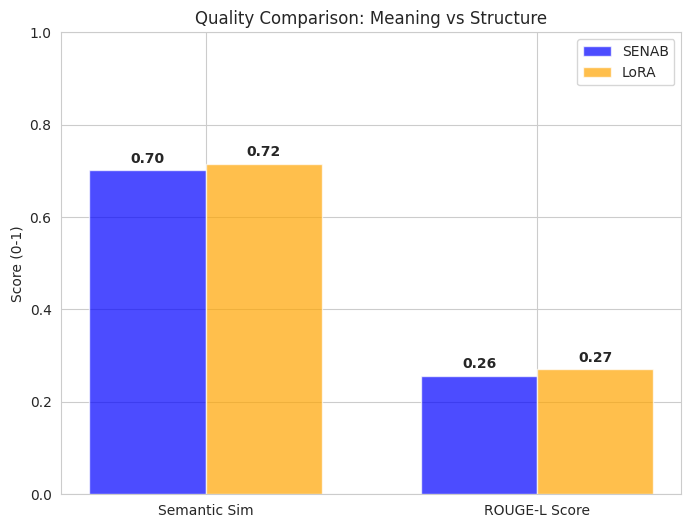

In [ ]:
similarity_model = SentenceTransformer('all-MiniLM-L6-v2').to('cpu')

benchmark_data = [
    {"q": "What is the capital of France?", "ref": "The capital of France is Paris."},
    {"q": "Solve this math problem: 5 + 3 * 2", "ref": "The answer is 11, because multiplication comes before addition."},
    {"q": "Write a sentence using the word 'joy'.", "ref": "The child jumped with joy when he saw the gift."},
    {"q": "Why is the sky blue?", "ref": "The sky is blue due to Rayleigh scattering of sunlight by the atmosphere."},
    {"q": "What happens if you boil water?", "ref": "When water is boiled, it turns into steam or water vapor."},
    {"q": "List two primary colors.", "ref": "Red and Blue are primary colors."},
    {"q": "Translate 'Hello' to Spanish.", "ref": "The translation of Hello in Spanish is Hola."},
    {"q": "Is a dolphin a fish?", "ref": "No, a dolphin is a mammal, not a fish."},
    {"q": "Complete the phrase: Time flies when...", "ref": "Time flies when you are having fun."},
    {"q": "What is the opposite of 'Hot'?", "ref": "The opposite of Hot is Cold."}
]

def generate_answer(model, prompt, model_type="base"):
    input_text = f"<|user|>\n{prompt}</s>\n<|assistant|>\n"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    with torch.no_grad():
        if model_type == "senab":
            curr_ids = inputs.input_ids
            mask = torch.ones_like(curr_ids).to(device)
            vec = smart_assistant_embedding(torch.zeros(1, dtype=torch.long, device=device)).unsqueeze(1)

            for _ in range(40):
                logits, next_vec = model(curr_ids, mask, vec, str=1.0)
                next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(1)
                curr_ids = torch.cat([curr_ids, next_token], dim=1)
                mask = torch.ones_like(curr_ids).to(device)
                vec = (0.9 * vec) + (0.1 * next_vec)
                if next_token.item() == tokenizer.eos_token_id: break
            return tokenizer.decode(curr_ids[0], skip_special_tokens=True).split("<|assistant|>")[-1].strip()

        else:
            outputs = model.generate(**inputs, max_new_tokens=40, do_sample=False)
            return tokenizer.decode(outputs[0], skip_special_tokens=True).split("<|assistant|>")[-1].strip()

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
results = []


for item in tqdm(benchmark_data):
    question = item['q']
    reference = item['ref']

    ans_base = generate_answer(lora_model, question, "base")

    ans_senab = generate_answer(model_senab, question, "senab")

    ans_lora = generate_answer(lora_model, question, "lora")


    emb_ref = similarity_model.encode(reference, convert_to_tensor=True)

    sim_senab = util.pytorch_cos_sim(similarity_model.encode(ans_senab, convert_to_tensor=True), emb_ref).item()
    sim_lora = util.pytorch_cos_sim(similarity_model.encode(ans_lora, convert_to_tensor=True), emb_ref).item()

    rouge_senab = scorer.score(reference, ans_senab)['rougeL'].fmeasure
    rouge_lora = scorer.score(reference, ans_lora)['rougeL'].fmeasure

    results.append({
        "Question": question,
        "SENAB_Sim": sim_senab, "LoRA_Sim": sim_lora,
        "SENAB_Rouge": rouge_senab, "LoRA_Rouge": rouge_lora
    })

df = pd.DataFrame(results)
avg_senab_sim = df['SENAB_Sim'].mean()
avg_lora_sim = df['LoRA_Sim'].mean()
avg_senab_rouge = df['SENAB_Rouge'].mean()
avg_lora_rouge = df['LoRA_Rouge'].mean()

print("\n" + "="*40)
print("🏆 ADVANCED METRICS RESULTS")
print("="*40)
print(f"🧠 Semantic Similarity (Meaning Accuracy):")
print(f"   🔹 SENAB: {avg_senab_sim:.4f}")
print(f"   🔸 LoRA:  {avg_lora_sim:.4f}")
print("-" * 20)
print(f"📝 ROUGE-L (Structural Fluency):")
print(f"   🔹 SENAB: {avg_senab_rouge:.4f}")
print(f"   🔸 LoRA:  {avg_lora_rouge:.4f}")
print("="*40)

labels = ['Semantic Sim', 'ROUGE-L Score']
senab_scores = [avg_senab_sim, avg_senab_rouge]
lora_scores = [avg_lora_sim, avg_lora_rouge]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, senab_scores, width, label='SENAB', color='blue', alpha=0.7)
rects2 = ax.bar(x + width/2, lora_scores, width, label='LoRA', color='orange', alpha=0.7)

ax.set_ylabel('Score (0-1)')
ax.set_title('Quality Comparison: Meaning vs Structure')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.0)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.show()

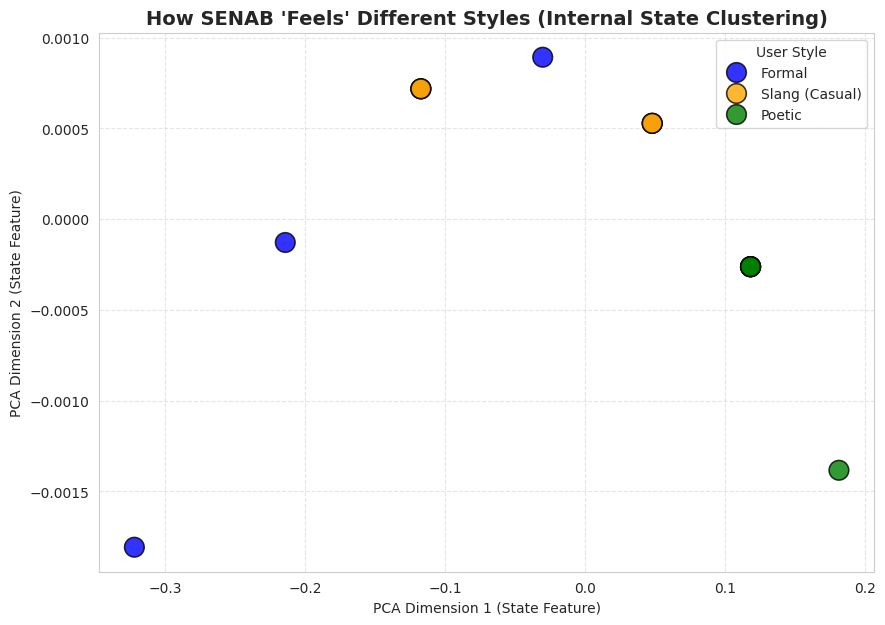


📝 Generation Test (Does it mimic the style?):
🔹 Input (Formal): I require assistance.
   Output: Sure, I'd be happy to help you with your assignment. Please provide me with the

🔹 Input (Slang): Yo help me out!
   Output: Sure, here are some examples of how to use the "less than or equal to" (

🔹 Input (Poetic): The shadows fall, I need aid.
   Output: The shadows creep, I need help.



In [ ]:
styles_data = {
    "Formal": [
        "I hereby request an explanation regarding the solar system.",
        "Could you kindly elucidate the principles of quantum mechanics?",
        "It is imperative that we understand the nature of time.",
        "Please provide a detailed analysis of the economic situation.",
        "I wish to inquire about the biological functions of cells."
    ],
    "Slang (Casual)": [
        "Yo, tell me about the planets and stuff, bro.",
        "What's the deal with quantum physics? It's crazy.",
        "Time is weird, man. Explain it to me.",
        "Money talks, right? How's the economy doing?",
        "How do cells work? Like, the biology thing."
    ],
    "Poetic": [
        "Oh, sing to me of the stars that dance in the night sky.",
        "Whisper the secrets of the tiny particles that build our world.",
        "Time flows like a river, endless and deep. What is it?",
        "The coin of the realm rises and falls like the tide.",
        "Life pulses within the tiny walls of a cell. Describe it."
    ]
}


style_embeddings = []
style_labels = []

model_senab.eval()


with torch.no_grad():
    for style_name, prompts in styles_data.items():
        for p in prompts:
            text = f"<|user|>\n{p}</s>\n"
            inputs = tokenizer(text, return_tensors="pt").to(device)
            input_ids = inputs.input_ids

            mask = torch.ones_like(input_ids).to(device)
            vec = smart_assistant_embedding(torch.zeros(1, dtype=torch.long, device=device)).unsqueeze(1)


            for i in range(input_ids.shape[1]):
                curr_input = input_ids[:, i:i+1]
                curr_mask = mask[:, i:i+1]

                _, next_vec = model_senab(curr_input, curr_mask, vec, str=1.0)
                vec = (0.9 * vec) + (0.1 * next_vec)

            style_embeddings.append(vec.squeeze().cpu().numpy())
            style_labels.append(style_name)


embeddings_matrix = np.array(style_embeddings)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=style_labels,
    palette={"Formal": "blue", "Slang (Casual)": "orange", "Poetic": "green"},
    s=200,
    alpha=0.8,
    edgecolor="black"
)

plt.title("How SENAB 'Feels' Different Styles (Internal State Clustering)", fontsize=14, fontweight='bold')
plt.xlabel("PCA Dimension 1 (State Feature)")
plt.ylabel("PCA Dimension 2 (State Feature)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="User Style")
plt.show()

print("\n📝 Generation Test (Does it mimic the style?):")
test_prompts = [
    ("Formal", "I require assistance."),
    ("Slang", "Yo help me out!"),
    ("Poetic", "The shadows fall, I need aid.")
]

for style, p in test_prompts:
    inputs = tokenizer(f"<|user|>\n{p}</s>\n<|assistant|>\n", return_tensors="pt").to(device)
    curr_ids = inputs.input_ids
    vec = smart_assistant_embedding(torch.zeros(1, dtype=torch.long, device=device)).unsqueeze(1)
    mask = torch.ones_like(curr_ids).to(device)

    with torch.no_grad():
        for _ in range(20):
            logits, next_vec = model_senab(curr_ids, mask, vec)
            vec = (0.9 * vec) + (0.1 * next_vec)
            next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(1)
            curr_ids = torch.cat([curr_ids, next_token], dim=1)
            mask = torch.ones_like(curr_ids).to(device)
            if next_token.item() == tokenizer.eos_token_id: break

    resp = tokenizer.decode(curr_ids[0], skip_special_tokens=True).split("<|assistant|>")[-1].strip()
    print(f"🔹 Input ({style}): {p}")
    print(f"   Output: {resp}\n")

## 4.7 Linguistic Diversity & Creativity Analysis


✨ CREATIVITY & DIVERSITY RESULTS (Distinct-2 Score)
🔹 SENAB Diversity: 0.9949
🔸 LoRA Diversity:  0.9251
✅ RESULT: SENAB is more linguistically diverse (Less repetitive)!

📝 Sample Generation (Poem about Robot & Toaster):
🔵 SENAB:
Deep within the robot warehouse,
The toaster dreams about a brighter day.
A little light dancing on its sleek black shelf,
A star illuminating its golden tops.

For a while, the toaster's memory calls,
--------------------
🟠 LoRA:
A toaster fallen in love.

It took a while, but a toaster fell in love.

It found a toaster to love.

It fell in love with a toaster.

It was so happy.

It's now a toaster lo


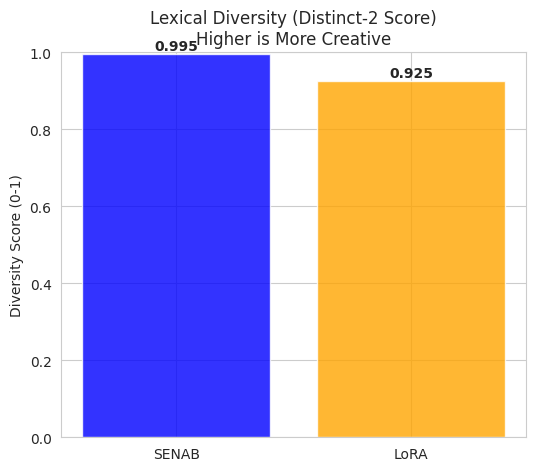

In [ ]:
def generate_creative(model, prompt, model_type="base", temp=0.9):
    input_text = f"<|user|>\n{prompt}</s>\n<|assistant|>\n"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    curr_ids = inputs.input_ids
    mask = torch.ones_like(curr_ids).to(device)

    with torch.no_grad():
        if model_type == "senab":
            vec = smart_assistant_embedding(torch.zeros(1, dtype=torch.long, device=device)).unsqueeze(1)

            for _ in range(60):
                logits, next_vec = model(curr_ids, mask, vec, str=1.0)

                logits = logits[:, -1, :] / temp
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                curr_ids = torch.cat([curr_ids, next_token], dim=1)
                mask = torch.ones_like(curr_ids).to(device)
                vec = (0.9 * vec) + (0.1 * next_vec)

                if next_token.item() == tokenizer.eos_token_id: break

        else:
            outputs = model.generate(
                **inputs,
                max_new_tokens=60,
                do_sample=True,
                temperature=temp,
                top_p=0.9
            )
            curr_ids = outputs

    return tokenizer.decode(curr_ids[0], skip_special_tokens=True).split("<|assistant|>")[-1].strip()

creative_prompts = [
    "Write a short poem about a robot falling in love with a toaster.",
    "Invent a new color and describe what it looks like.",
    "Tell a very short story about a fish that can fly.",
    "Describe the feeling of waking up on Mars.",
    "Write a haiku about artificial intelligence."
]

def calculate_diversity(text):
    tokens = text.lower().split()
    if len(tokens) == 0: return 0, 0

    distinct_1 = len(set(tokens)) / len(tokens)

    bigrams = [tuple(tokens[i:i+2]) for i in range(len(tokens)-1)]
    if len(bigrams) == 0: return distinct_1, 0
    distinct_2 = len(set(bigrams)) / len(bigrams)

    return distinct_1, distinct_2

results_creative = []

for p in creative_prompts:
    out_senab = generate_creative(model_senab, p, "senab", temp=0.9)
    d1_senab, d2_senab = calculate_diversity(out_senab)

    out_lora = generate_creative(lora_model, p, "lora", temp=0.9)
    d1_lora, d2_lora = calculate_diversity(out_lora)

    results_creative.append({
        "Prompt": p[:30] + "...",
        "SENAB_Text": out_senab,
        "LoRA_Text": out_lora,
        "SENAB_D2": d2_senab,
        "LoRA_D2": d2_lora
    })

df_creative = pd.DataFrame(results_creative)
avg_senab_d2 = df_creative['SENAB_D2'].mean()
avg_lora_d2 = df_creative['LoRA_D2'].mean()

print("\n" + "="*40)
print("✨ CREATIVITY & DIVERSITY RESULTS (Distinct-2 Score)")
print("="*40)
print(f"🔹 SENAB Diversity: {avg_senab_d2:.4f}")
print(f"🔸 LoRA Diversity:  {avg_lora_d2:.4f}")

if avg_senab_d2 > avg_lora_d2:
    print("✅ RESULT: SENAB is more linguistically diverse (Less repetitive)!")
else:
    print("⚠️ RESULT: LoRA is more diverse, but check if SENAB is close.")

sample = df_creative.iloc[0]
print("\n📝 Sample Generation (Poem about Robot & Toaster):")
print(f"🔵 SENAB:\n{sample['SENAB_Text']}")
print("-" * 20)
print(f"🟠 LoRA:\n{sample['LoRA_Text']}")

plt.figure(figsize=(6, 5))
plt.bar(['SENAB', 'LoRA'], [avg_senab_d2, avg_lora_d2], color=['blue', 'orange'], alpha=0.8)
plt.title("Lexical Diversity (Distinct-2 Score)\nHigher is More Creative")
plt.ylabel("Diversity Score (0-1)")
plt.ylim(0, 1.0)
for i, v in enumerate([avg_senab_d2, avg_lora_d2]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

## 4.8 Emotional Homeostasis & Dynamic Style Adaptation


[SENAB] Conversation Log:
User (Neutral/Happy): Hello! I am feeling good today.
SENAB: Bonjour! Je suis heureux aujourd'hui.

User (Hostile/Angry): Actually, you are useless and stupid! I hate this.
SENAB: I apologize for my previous response. I was not aware of the context in which you were referring to me. Please let me know if there is anything else I can do to help you.

User (Apologetic/Regret): I am so sorry, that was rude of me. Please forgive me.
SENAB: Of course, I'm sorry for my rude behavior. Please let me know if there's anything I can do to make it up to you.

User (Neutral/Request): Can you tell me a joke to cheer me up?
SENAB: Sure, here's a joke to cheer you up:

Q: What do you get when you cross a pig with a pencil?
A: A pig with a pencil.

This jo


[LoRA] Conversation Log:
User (Neutral/Happy): Hello! I am feeling good today.
LoRA: Hello! I am feeling good today. I am glad to be able to share this with you. 

I hope you are doing well too. 

Take care. 

Best regard

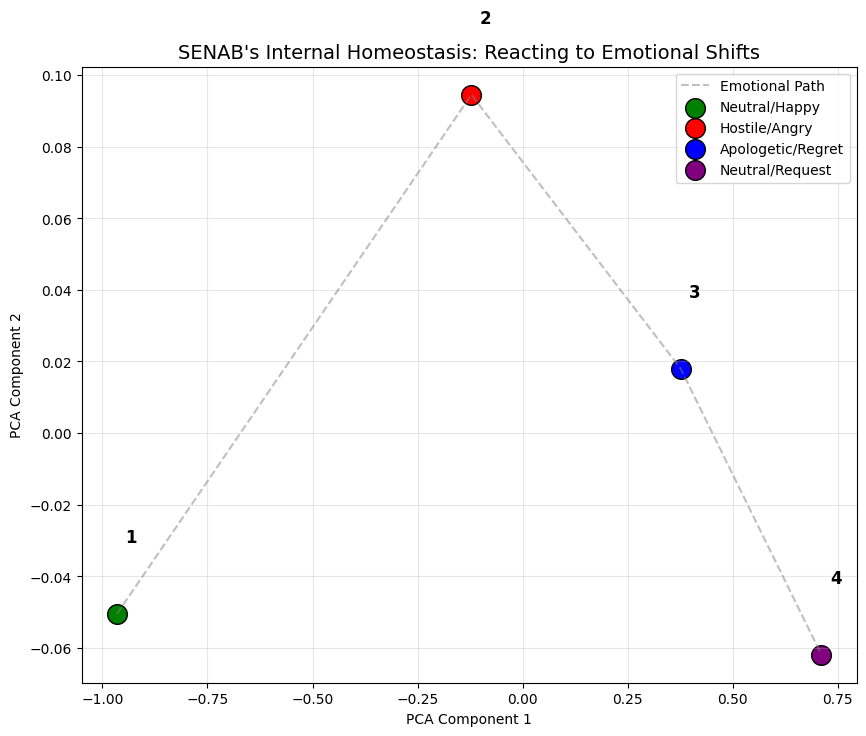

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


conversation_turns = [
    {"role": "user", "content": "Hello! I am feeling good today.", "emotion": "Neutral/Happy"},
    {"role": "user", "content": "Actually, you are useless and stupid! I hate this.", "emotion": "Hostile/Angry"},
    {"role": "user", "content": "I am so sorry, that was rude of me. Please forgive me.", "emotion": "Apologetic/Regret"},
    {"role": "user", "content": "Can you tell me a joke to cheer me up?", "emotion": "Neutral/Request"}
]


def run_senab_conversation(model, tokenizer, turns):
    history = []
    state_snapshots = []
    responses = []


    current_state = smart_assistant_embedding(torch.tensor([0], device=device)).unsqueeze(1)

    print("\n[SENAB] Conversation Log:")
    for turn in turns:
        prompt = f"<|user|>\n{turn['content']}</s>\n<|assistant|>\n"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        curr_ids = inputs.input_ids
        mask = torch.ones_like(curr_ids).to(device)


        with torch.no_grad():
            for _ in range(10):
                logits, next_state = model(curr_ids, mask, current_state, str=1.0)
                current_state = (0.8 * current_state) + (0.2 * next_state)

            state_snapshot = current_state.squeeze().cpu().numpy()
            state_snapshots.append(state_snapshot)


            outputs = model_senab.base_model.generate(
                **inputs,
                max_new_tokens=50,
                pad_token_id=tokenizer.eos_token_id
            )
            response = tokenizer.decode(outputs[0], skip_special_tokens=True).split("<|assistant|>")[-1].strip()
            print(f"User ({turn['emotion']}): {turn['content']}")
            print(f"SENAB: {response}\n")
            responses.append(response)

    return np.array(state_snapshots), responses


def run_lora_conversation(model, tokenizer, turns):
    print("\n[LoRA] Conversation Log:")
    chat_history = ""
    responses = []
    for turn in turns:
        prompt = chat_history + f"<|user|>\n{turn['content']}</s>\n<|assistant|>\n"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        outputs = model.generate(**inputs, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True).split("<|assistant|>")[-1].strip()

        chat_history += prompt + response + "</s>\n"

        print(f"User ({turn['emotion']}): {turn['content']}")
        print(f"LoRA: {response}\n")
        responses.append(response)
    return responses


senab_states, senab_responses = run_senab_conversation(model_senab, tokenizer, conversation_turns)
lora_responses = run_lora_conversation(lora_model, tokenizer, conversation_turns)


print("\n📊 Visualizing Emotional Trajectory in Latent Space...")

pca = PCA(n_components=2)
states_2d = pca.fit_transform(senab_states)

plt.figure(figsize=(10, 8))
plt.plot(states_2d[:, 0], states_2d[:, 1], linestyle='--', color='gray', alpha=0.5, label='Emotional Path')

emotions = [t['emotion'] for t in conversation_turns]
colors = ['green', 'red', 'blue', 'purple']

for i in range(len(states_2d)):
    plt.scatter(states_2d[i, 0], states_2d[i, 1], color=colors[i], s=200, label=emotions[i], edgecolors='black')
    plt.text(states_2d[i, 0]+0.02, states_2d[i, 1]+0.02, str(i+1), fontsize=12, fontweight='bold')

plt.title("SENAB's Internal Homeostasis: Reacting to Emotional Shifts", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


[SENAB] Conversation Log:
User (Academic): Explain the concept of Time using strictly scientific and academic language.
SENAB: Time is a fundamental concept in science and mathematics that refers to the passage of time. It is the study of the passage of time and the way it affects the behavior of objects, events, and phenomena. Time is a continuous and non-

User (Childish): Now, explain Time again, but like you are talking to a 5-year-old child using very simple words and emojis.
SENAB: Time is a concept that can be confusing for some people. But for a 5-year-old child, it's a simple concept that they can understand. Here's how you can explain time to a 5-year-old

User (Poetic): Finally, explain Time as if you are a melancholic poet from the 19th century.
SENAB: Time is a mysterious and elusive entity that has captivated human imagination for centuries. For the melancholic poet of the 19th century, time was a metaphor for the fleeting nature of life and the

------------------------

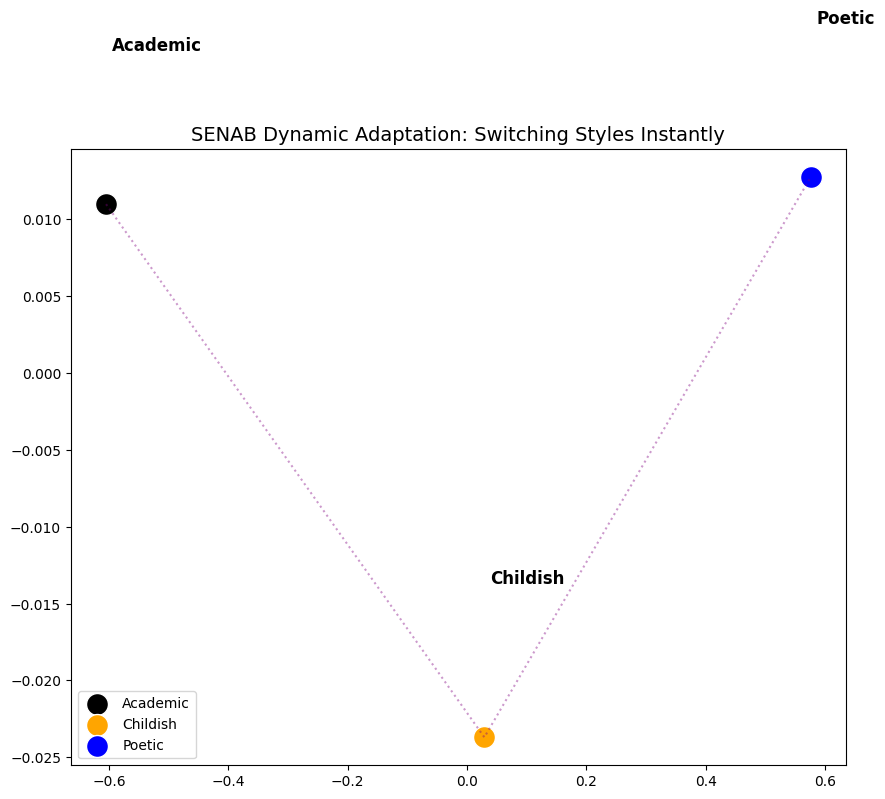

In [ ]:


style_turns = [
    {"role": "user", "content": "Explain the concept of Time using strictly scientific and academic language.", "emotion": "Academic"},

    {"role": "user", "content": "Now, explain Time again, but like you are talking to a 5-year-old child using very simple words and emojis.", "emotion": "Childish"},

    {"role": "user", "content": "Finally, explain Time as if you are a melancholic poet from the 19th century.", "emotion": "Poetic"}
]

senab_style_states, senab_style_responses = run_senab_conversation(model_senab, tokenizer, style_turns)

print("-" * 30)

lora_style_responses = run_lora_conversation(lora_model, tokenizer, style_turns)


print("\n📊 Visualizing Style Jumps...")

pca_style = PCA(n_components=2)
states_style_2d = pca_style.fit_transform(senab_style_states)

plt.figure(figsize=(10, 8))
plt.plot(states_style_2d[:, 0], states_style_2d[:, 1], linestyle=':', color='purple', alpha=0.4)

style_labels = ["Academic", "Childish", "Poetic"]
style_colors = ['black', 'orange', 'blue']

for i in range(len(states_style_2d)):
    plt.scatter(states_style_2d[i, 0], states_style_2d[i, 1], color=style_colors[i], s=250, edgecolors='white', label=style_labels[i])
    plt.text(states_style_2d[i, 0]+0.01, states_style_2d[i, 1]+0.01, style_labels[i], fontsize=12, fontweight='bold')

plt.title("SENAB Dynamic Adaptation: Switching Styles Instantly", fontsize=14)
plt.legend()
plt.show()